# Text Preprocessing and Augmentation

In this notebook, we will work with text data. Firstly, we will learn how to perform preprocessing and visualization on text data. Then, we will try to adopt data augmentation on text data. The Enron email datasets will be used here to demonstrate how text mining/NLP techniques could be used for fraud analysis. Through the whole example, we will mainly use the following two NLP libraries:

1. [Texthero](https://pypi.org/project/texthero/)

2. [nlpaug](https://nlpaug.readthedocs.io/en/latest/)  

# 1. Data Background

In 2000, [Enron](https://en.wikipedia.org/wiki/Enron) was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 


The Enron fraud is the largest case of corporate fraud in American history. Founded in 1985, Enron Corporation went bankrupt by end of 2001 due to widespread corporate fraud and corruption. Before its fall, Fortune magazine had named Enron "America's most innovative company" for six consecutive years. So what happened? Who were the culprits?

In this notebook, we are going to work with emails corpus from Enron employees. We will learn how to analyze text data for fraud analysis.

In [1]:
basefn = "..//data//"
import pandas as pd
df_corpus = pd.read_csv(basefn + "enron_emails_clean.csv")

In [2]:
df_corpus.head()

,Message-ID,Date,content
0,<8345058.1075840404046.JavaMail.evans@thyme>,2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...
1,<1512159.1075863666797.JavaMail.evans@thyme>,2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...
2,<26118676.1075862176383.JavaMail.evans@thyme>,2001-10-30 16:15:17,hey you are not wearing your target purple shi...
3,<10369289.1075860831062.JavaMail.evans@thyme>,2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...
4,<26728895.1075860815046.JavaMail.evans@thyme>,2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501..."


#### Exact Word Match
One simple approach to analyze text data is keyword based query. For example, look for any emails mentioning 'money'. Here, the query word could be any informative words.

In [3]:
# Select data that matches 
df_corpus.loc[df_corpus['content'].str.contains('money', na=False)].head(3)


,Message-ID,Date,content
0,<8345058.1075840404046.JavaMail.evans@thyme>,2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,2001-10-30 16:15:17,hey you are not wearing your target purple shi...
3,<10369289.1075860831062.JavaMail.evans@thyme>,2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...


Usually you want to search more than one term. For example, in fraud analysis, you may prepare a full **fraud word lists** including terms that could potentially flag fraudulent clients and/or transactions. 

Here, we create a list containing the following words/terms:

* 'enron stock'
* 'sell stock'
* 'stock bonus'
* 'sell enron stock'.

In [4]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

filtered_emails  = df_corpus.loc[df_corpus['content'].str.contains('|'.join(searchfor), na=False)]
filtered_emails.head(2)

,Message-ID,Date,content
2,<26118676.1075862176383.JavaMail.evans@thyme>,2001-10-30 16:15:17,hey you are not wearing your target purple shi...
8,<19319259.1075862176360.JavaMail.evans@thyme>,2001-10-30 16:05:30,"2-5, so much for the nice machine\n\n\n -----O..."


In [5]:
print("Number of returned fraud emails is {}".format(filtered_emails.shape[0]))

Number of returned fraud emails is 13


The recall rate is quite low because the search keyword has to be exactly identical to the words in the emails to be found. For example, the email containing "SELL stock" will not be counted. In the following, we will use text preprocessing techniques from **texthero** to improve the recall rate. 

# 2. Texthero

<img src="https://texthero.org/img/T.png" alt="logo" style="width: 50px;"/>

Texthero is a simple Python toolkit that helps you work with a text-based dataset. It provides quick and easy functionalities that let you preprocess, represent, map into vectors and visualize text data in just a couple of lines of code.

Texthero is designed to be used on top of **pandas**, so it makes it easier to preprocess and analyze text-based Pandas Series or Dataframes.

If you are working on an NLP project, Texthero can help you get things done faster than before and gives you more time to focus on important tasks.

NOTE: The Texthero library is still in the beta version. You might face some bugs and pipelines might change. A faster and better version will be released and it will bring some major changes.

Install Package
```
pip install texthero
```

In [6]:
!pip install texthero==1.1.0 -q

Texthero has four useful modules that handle different functionalities that you can apply in your text-based dataset.

- Preprocessing

  This module allows for the efficient pre-processing of text-based Pandas Series or DataFrames. It has different methods to clean your text dataset such as lowercase(), remove_html_tags() and remove_urls().


- NLP

  This module has a few NLP tasks such as named_entities, noun_chunks, and so on.

- Representation

  This module has different algorithms to map words into vectors such as TF-IDF,  GloVe, Principal Component Analysis(PCA), and term_frequency.

- Visualization

  The last module has three different methods to visualize the insights and statistics of a text-based Pandas DataFrame. It can plot a scatter plot and word cloud.

In this section, we will focus on two parts: **preprocessing** and **Visualization**

In [7]:
import texthero as hero

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047085 sha256=e2db8eccde6b53091047aba536ad246f7bec468776f5cd868507b11480eea111
  Stored in directory: /Users/ruizhao/Library/Caches/pip/wheels/19/d6/1c/5484b95647df5d7afaf74abde458c66c1cd427e69e801fe826
Successfully built en_core_web_sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


#### Text Preprocessing

Texthero provides useful text preprocessing methods. For example, 
* Remove digits
* Remove stopwords
* Remove URLs
* Tokenize
* Remove HTML tags

All the required inputs should be **Pandas series** or Pandas dataframe

In [8]:
text = pd.Series("Hi my phone number is +86 12394 call me at 09:00 am")
clean_text = hero.preprocessing.remove_digits(text)

print(clean_text)

0    Hi my phone number is +    call me at  :  am
dtype: object


In [9]:
text = pd.Series("you need to know machine learning")
clean_text = hero.remove_stopwords(text)

print(clean_text) 

0     need  know machine learning
dtype: object


In [10]:
text = pd.Series("Go to https://spacy.io/ to read more articles you like")
clean_text = hero.remove_urls(text)

print(clean_text)

0    Go to   to read more articles you like
dtype: object


In [11]:
text = pd.Series(["You can think of Texthero as a tool to help you understand and work with text-based dataset. "])
clean_text = hero.tokenize(text)

print(clean_text)

0    [You, can, think, of, Texthero, as, a, tool, t...
dtype: object


In [12]:
text = pd.Series("<html><body><h2>hello world</h2></body></html>")
clean_text = hero.remove_html_tags(text)

print(clean_text)

0    hello world
dtype: object


Texthero provide a simple interface named **clean()**.

The clean() method runs seven functions when you pass a pandas series. These seven functions are:

* lowercase(s): Lowercases all text.
* remove_diacritics(): Removes all accents from strings.
* remove_stopwords(): Removes all stop words.
* remove_digits(): Removes all blocks of digits.
* remove_punctuation(): Removes all string.punctuation (!"#$%&'()*+,-./:;<=>?@[]^_`{|}~).
* fillna(s): Replaces unassigned values with empty spaces.
* remove_whitespace(): Removes all white space between words

Now we can see the cleaned news content.

In [13]:
# clean the news content by using clean method from hero package
df_corpus['clean_content'] = hero.clean(df_corpus['content'])

In [14]:
#show unclean and clean news content

df_corpus[['content','clean_content']].head(2)

,content,clean_content
0,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...


We can also modify the **clean()** function. Then, we can call the customized text clean functions.


In [15]:
#create custom pipeline
custom_pipeline = [hero.preprocessing.fillna,
                   hero.preprocessing.lowercase,
                   hero.preprocessing.remove_whitespace,
                   hero.preprocessing.remove_urls
                   ]

In [16]:
df_corpus['clean_custom_content'] = df_corpus['content'].pipe(hero.clean, custom_pipeline)

#### Search the email corpus again

Here, we search the cleaned email corpus

In [17]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

filtered_emails  = df_corpus.loc[df_corpus['clean_content'].str.contains('|'.join(searchfor), na=False)]
print("Number of returned fraud emails after text preprocessing is {}".format(filtered_emails.shape[0]))

Number of returned fraud emails after text preprocessing is 314


After text preprocessing, the recall rate is improved



#### Visualization 

Then, let us explore some text visualization methods in texthero. Texthero contains different method to visualize insights and statistics of a text-based Pandas DataFrame.

* Top words

  If you want to know the top words in your text-based dataset, you can use the top_words() method from the visualization module. This method is useful if you want see additional words that you can add to the stop words lists.

* Wordclouds

  The wordcloud() method from the visualization module plots an image using WordCloud from the word_cloud package.

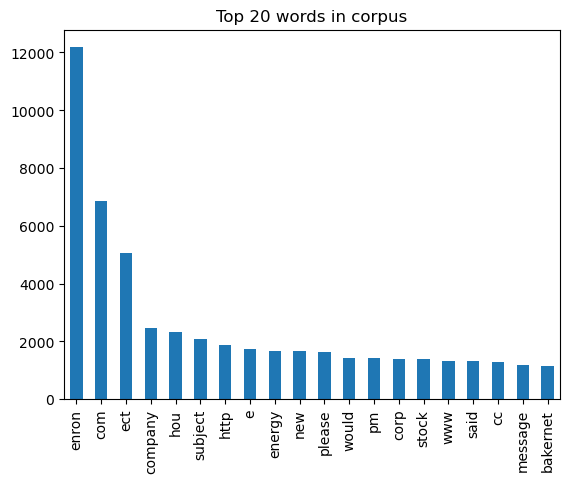

In [18]:
import matplotlib.pyplot as plt
NUM_TOP_WORDS = 20
top_20 = hero.visualization.top_words(df_corpus.loc[:, 'clean_content']).head(NUM_TOP_WORDS)
top_20.plot.bar(rot=90, title="Top 20 words in corpus");
plt.show(block=True);

#### Wordclouds

The wordcloud() method from the visualization module plots an image using WordCloud from the word_cloud package.



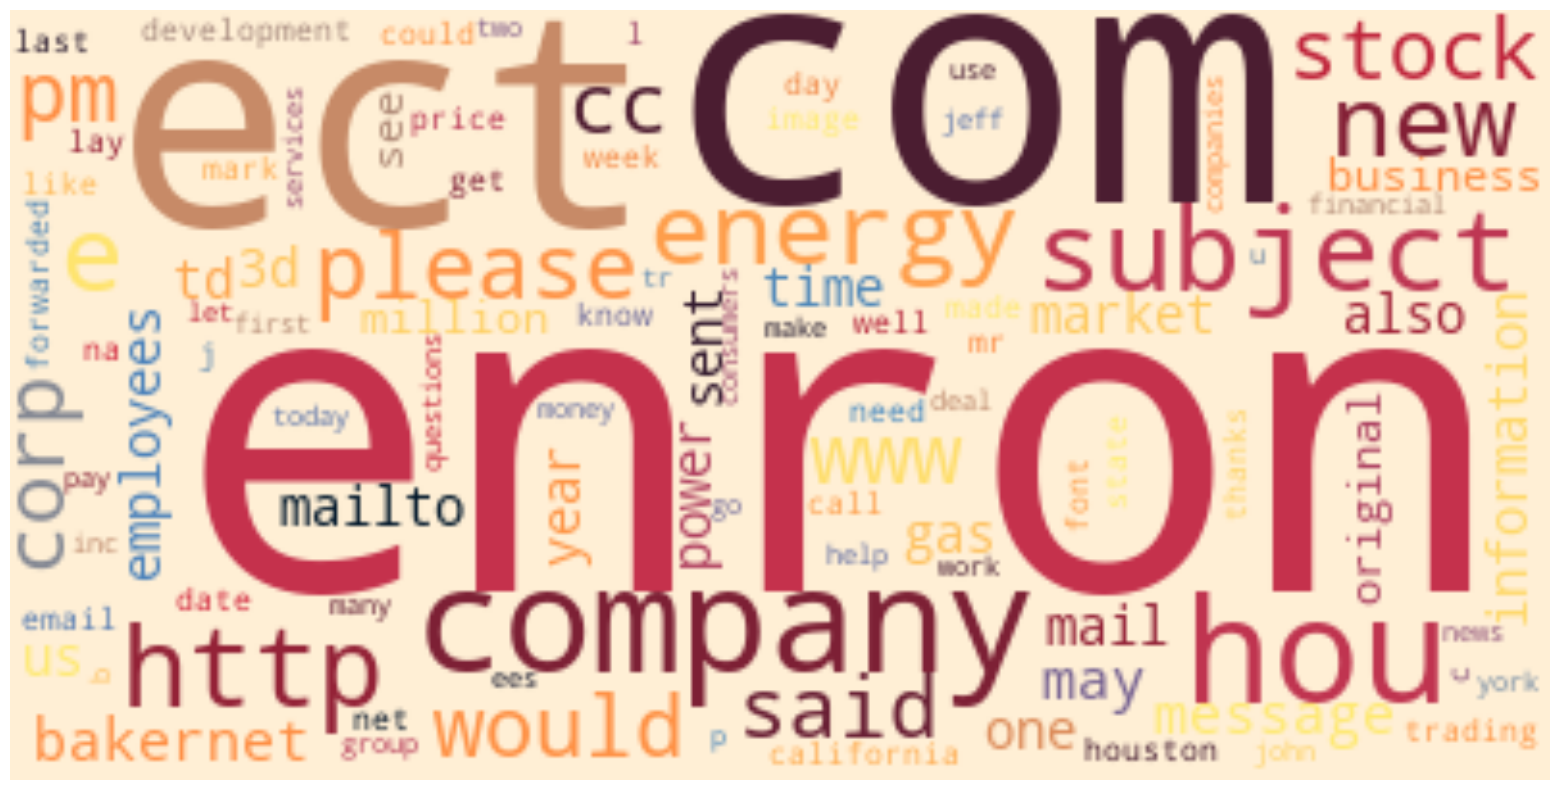

In [19]:
#Plot wordcloud image using WordCloud method
hero.wordcloud(df_corpus.loc[:, 'clean_content'], max_words=100)

# 3. NLPAUG

![https://github.com/makcedward/nlpaug/blob/master/res/logo_small.png?raw=true](https://github.com/makcedward/nlpaug/blob/master/res/logo_small.png?raw=true)

More data we have, better performance we can achieve. What is more, sample more data from minority class is one approach to address the imbalanced problem.   However, it is very costy to annotate large amount of training data. And in some applications includign fraud detection, it is impossible to obtain lots of data labeled as fraud one. Therefore, proper data augmentation is useful to boost up your model performance.

Due to high complexity of language, it is more challenging to augment text compared to images which can simply cropping out portion of images. Here, we will explore the library named nlpaug. This python library helps you with augmenting nlp for your machine learning projects. 

Provided Features listed as:

1. Generate synthetic data for improving model performance without manual effort
2. Simple, easy-to-use and lightweight library. Augment data in 3 lines of code
3. Plug and play to any neural network frameworks (e.g. PyTorch, TensorFlow)
4. Support textual and audio input


Install Package

In [20]:
!pip install nlpaug==1.1.10 -q

In [21]:
df_corpus['Tag'] = 0
df_corpus.loc[df_corpus['clean_content'].str.contains('|'.join(searchfor), na=False), 'Tag'] = 1
df_corpus['Tag'].value_counts()

0    1776
1     314
Name: Tag, dtype: int64

This library nlpaug provides various textual augmenter functions including character augmenter, word augmenter and sentence augmenter. 

In this section, we will only explore word-level augmentation based on [WordNet](https://wordnet.princeton.edu/): substitute word by WordNet's synonym.

You may find other frameworks [here](https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb)

In [22]:
texts = df_corpus.loc[df_corpus.Tag==1, 'clean_content'].tolist()
short_email = min(texts, key=lambda word: len(word)) 
#for better visualization, find the shortest email
short_email

'taxes owe based gain whatever sell much less instance bought enron stock noe worth pay tax gain look tonight'

In [23]:
import nlpaug.augmenter.word as naw

#### Install WordNet

In [24]:
# download nltk resources
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ruizhao/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/ruizhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ruizhao/nltk_data...


True

In [25]:
aug = naw.SynonymAug(aug_src='wordnet')
augmented_texts = aug.augment(short_email, 5) # 5 is the number of generated text
print("Original:")
print(short_email)
print("Augmented Texts:")
for idx in range(len(augmented_texts)):
    print(augmented_texts[idx])

Original:
taxes owe based gain whatever sell much less instance bought enron stock noe worth pay tax gain look tonight
Augmented Texts:
taxes owe based gain whatsoever sell very much less instance bought enron farm animal noe deserving pay tax gain look tonight
taxes owe establish gain whatsoever sell much less example bought enron stock noe worth pay tax gain look tonight
taxes owe based gain whatever sell much less instance bought enron stock noe worth give taxation gain tone tonight
taxes owe based gain whatsoever sell a lot less instance bought enron livestock noe worth pay tax gain flavor tonight
taxation owe based increase whatever sell often less instance bought enron stock noe worth pay taxation gain look tonight
